In [1]:
import os

from phi.jax import flow
from phi.jax.flow import Solve
import phi
# https://physicsbaseddeeplearning.org/diffphys-code-ns.html --> solution to divergence problems and warnings

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
"""
Solves the incompressible Navier-Stokes equations in conjunction with
an advection equation in a closed box.

Momentum:           ∂u/∂t + (u ⋅ ∇) u = − 1/ρ ∇p + ν ∇²u + f

Incompressibility:  ∇ ⋅ u = 0

Advection:          ∂s/∂t + (u ⋅ ∇) s = α ∇²s + i

u:  Velocity (2d vector)
p:  Pressure
f:  Forcing (here due to Buoyancy)
ν:  Kinematic Viscosity
ρ:  Density (here =1.0)
t:  Time
∇:  Nabla operator (defining nonlinear convection, gradient and divergence)
∇²: Laplace Operator
s:  Concentration of a species (here hot smoke)
α:  Diffusivity of the embedded species
i:  Inflow of hot smoke into the domain.

----------

Scenario


    +----------------------------------------------+
    |                                              |
    |                                              |
    |                                              |
    |                                              |
    |                                              |
    |                                              |
    |                                              |
    |                                              |
    |                                              |
    |                                              |
    |                                              |
    |                                              |
    |           _                                  |
    |          / \                                 |
    |         |   |                                |
    |          \_/                                 |
    |                                              |
    +----------------------------------------------+

-> Domain is square and closed-off (wall BC everywhere)
-> Initially, the fluid is at rest
-> Initially, the concentration of smoke is zero everywhere
-> There is a continuous inflow of hot smoke in a small circular
   patch in the bottom left of the domain
-> The hot smoke exerts a force on the fluid due to Buyancy
-> This makes the fluid flow upwards and create a plume pattern

-------

Solution strategy:

Initialize the fluid velocity vectors to zero on a Staggered Grid.

Initialize the smoke density to zero on a Centered Grid.

1. Advect the smoke density by a MacCormack step

2. Add the inflow of hot smoke to the smoke density field

3. Compute the Buoyancy force by re-sampling the centered
   smoke densities on the staggered velocities

4. Convect the fluid by means of a semi-lagrangian self-avection
   step 

5. Add the Buoyancy force to the fluid

6. Make the fluid incompressible

7. Repeat


Note, that we did not apply any diffusion on both the fluid and
the smoke concentration. This is done for simplicity, the involved
convection/advection procedures introduce considerable numerical
diffusion which stabilize the simulation.
"""

plt.style.use("dark_background")

N_TIME_STEPS = 150

def run_simulation():

    velocity = flow.StaggeredGrid(
        values=(0.0, 0.0),
        extrapolation=0.0,
        x=64,
        y=64,
        bounds=flow.Box(x=100, y=100),
    )
    smoke = flow.CenteredGrid(
        values=0.0,
        extrapolation=flow.extrapolation.BOUNDARY,
        x=64,
        y=64,
        bounds=flow.Box(x=100, y=100),
    )
    inflow = 0.2 * flow.CenteredGrid(
        values=flow.field.mask(
            flow.Sphere(
                x=np.random.randint(10,90),
                y=np.random.randint(10,90),
                radius=5,
            )
        ),
        extrapolation=0.0,
        bounds=smoke.bounds,
        resolution=smoke.resolution,
    )

    @flow.jit_compile
    def step(velocity_prev, smoke_prev, dt=1.0):
        smoke_next = flow.advect.mac_cormack(smoke_prev, velocity_prev, dt) + inflow
        buoyancy_force = smoke_next * (0.0, 0.1) @ velocity_prev
        velocity_tent = flow.advect.semi_lagrangian(velocity_prev, velocity_prev, dt) + buoyancy_force * dt
        velocity_next, pressure = flow.fluid.make_incompressible(velocity_tent, [], Solve('CG', 1e-3, rank_deficiency=0, suppress=[phi.math.NotConverged]))
        return velocity_next, smoke_next, pressure
    
    velocity_array = []
    smoke_array = []
    pressure_array = []
    
    for _ in tqdm(range(N_TIME_STEPS)):
        velocity, smoke, pressure = step(velocity, smoke)
        
        velocity_array.append(velocity)
        smoke_array.append(smoke)
        pressure_array.append(pressure)
    
    # Convert to numpy arrays

    velocity_array = [(vel.numpy("y,x")[0], vel.numpy("y,x")[1]) for vel in velocity_array]  # velocity_x, velocity_y
    velocity_array = [(np.pad(vel[0], ((0,0), (0,1)), mode="edge"), np.pad(vel[1], ((0,1), (0,0)), mode="edge")) for vel in velocity_array]  # Pad to same size
    velocity_array = np.array(velocity_array)
    velocity_array = np.moveaxis(velocity_array, 1, 3)  # [T, H, W, C]

    pressure_array = np.array([p.numpy("y,x") for p in pressure_array])

    smoke_array = np.array([s.numpy("y,x") for s in smoke_array])
    
    return velocity_array, smoke_array, pressure_array


import numpy as np
from PIL import Image

def save_gif(smoke_array, velocity_array, pressure_array, file_num):
    # Scale to 0 - 255
    # NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
    smoke_array_scaled = (((smoke_array - smoke_array.min()) * 255) / (smoke_array.max() - smoke_array.min())).astype(np.uint8)
    velocity_array_scaled = (((velocity_array - velocity_array.min()) * 255) / (velocity_array.max() - velocity_array.min())).astype(np.uint8)
    pressure_array_scaled = (((pressure_array - pressure_array.min()) * 255) / (pressure_array.max() - pressure_array.min())).astype(np.uint8)

    data_dict = {"rho": smoke_array_scaled,
                "u": velocity_array_scaled[:,:,:,0],
                "v": velocity_array_scaled[:,:,:,1],
                "p": pressure_array_scaled}

    for name, img_array in data_dict.items():

        imgs = [Image.fromarray(img) for img in img_array]
        # duration is the number of milliseconds between frames; this is 40 frames per second
        imgs[0].save(f"data/{file_num}/{name}.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

<>:42: SyntaxWarning: invalid escape sequence '\ '
<>:42: SyntaxWarning: invalid escape sequence '\ '
C:\Users\juanj\AppData\Local\Temp\ipykernel_24496\4114285980.py:42: SyntaxWarning: invalid escape sequence '\ '
  |          / \                                 |


In [ ]:
for i in range(100):
    
    # Get simulation data
    velocity_array, smoke_array, pressure_array = run_simulation()
    
    if not os.path.exists(f"data/{i}"):
        os.makedirs(f"data/{i}")

    # Save data
    # np.save(f"data/{i}/velocity.npy", velocity_array.astype(np.float32))
    # np.save(f"data/{i}/smoke.npy", smoke_array.astype(np.float32))
    # np.save(f"data/{i}/pressure.npy", pressure_array.astype(np.float32))
    
    save_gif(smoke_array, velocity_array, pressure_array, i)

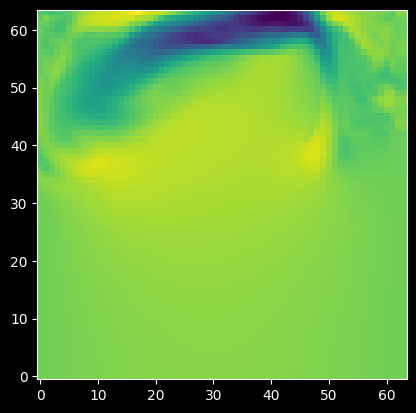

In [6]:
idx = 149

img_smoke = smoke_array[idx]
img_velocity_x, img_velocity_y = velocity_array[idx,:,:,0], velocity_array[idx,:,:,1]
img_pressure = pressure_array[idx]

plt.imshow(img_velocity_x, origin="lower")